<a href="https://colab.research.google.com/github/kenta321/Projects/blob/main/FFT_ditch_potential.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install librosa scikit-learn mat73 pandas tqdm --quiet

In [ ]:
import mat73
import numpy as np
import pandas as pd

sig_dict = mat73.loadmat('/content/drive/MyDrive/model data/Circor_aug_5s.mat')
All_sig = sig_dict['Circor_aug_5s'].T.astype(np.float32)
print("Signal shape:", All_sig.shape)

Labels = pd.read_excel("/content/drive/MyDrive/model data/Label_aug_5s.xlsx", header=None)
All_label = Labels.values.squeeze().astype(np.int64)
print("Labels shape:", All_label.shape)


Signal shape: (48369, 10000)
Labels shape: (48369,)


In [ ]:
!pip install pennylane pennylane-qiskit librosa matplotlib torch torchvision torchaudio scikit-learn --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.1/797.1 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 746.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 100.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 713.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

In [ ]:
import numpy as np
All_label = All_label.reshape(-1)
print("Labels shape:", All_label.shape)

All_sig = np.array(All_sig)
All_label = np.array(All_label)

Labels shape: (48369,)


In [ ]:
import torch

In [ ]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [ ]:
from scipy.fft import fft

In [ ]:

class PCGDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        signal = self.data[idx]
        label = self.labels[idx]

        fft_signal = np.abs(np.fft.fft(signal))[:len(signal)//2]
        fft_signal = (fft_signal - np.min(fft_signal)) / (np.max(fft_signal) - np.min(fft_signal) + 1e-8)

        fft_tensor = torch.tensor(fft_signal, dtype=torch.float32).unsqueeze(0)
        label_tensor = torch.tensor(label, dtype=torch.long)
        return fft_tensor, label_tensor


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(All_sig, All_label, test_size=0.2, stratify=All_label)

train_dataset = PCGDataset(X_train, y_train)
test_dataset = PCGDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import pennylane as qml
from pennylane.templates import BasicEntanglerLayers

n_qubits = 4
dev = qml.device("lightning.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

weight_shapes = {"weights": (6, n_qubits)}

class QuantumLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.q_layer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)

    def forward(self, x):
        return self.q_layer(x)


/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


In [ ]:

class Conv1DQuantumNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv1d(10, 20, kernel_size=5)
        self.dropout = nn.Dropout(0.2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(99840, 32)
        self.fc2 = nn.Linear(32, n_qubits)
        self.q_layer = QuantumLayer()
        self.fc3 = nn.Linear(n_qubits, 3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.q_layer(x)
        x = self.fc3(x)
        return x


In [ ]:
from tqdm import tqdm

In [ ]:
def train_model(model, train_loader, optimizer, criterion, epochs=5, device='cuda'):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

        print(f"Epoch {epoch+1} Loss: {running_loss / len(train_loader):.4f}")

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:

def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            output = model(X_batch)
            preds = torch.argmax(output, dim=1).cpu().numpy()
            y_true.extend(y_batch.numpy())
            y_pred.extend(preds)

    acc = 100 * np.mean(np.array(y_true) == np.array(y_pred))
    print(f"Test Accuracy: {acc:.2f}%")

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix - Accuracy: {acc:.2f}%")
    plt.show()


model = Conv1DQuantumNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train_model(model, train_loader, optimizer, criterion, epochs=8)



Epoch 1/8: 100%|██████████| 1210/1210 [22:06<00:00,  1.10s/it, loss=1.01]


Epoch 1 Loss: 1.0803


Epoch 2/8: 100%|██████████| 1210/1210 [21:38<00:00,  1.07s/it, loss=0.986]


Epoch 2 Loss: 1.0502


Epoch 3/8: 100%|██████████| 1210/1210 [21:42<00:00,  1.08s/it, loss=1.28]


Epoch 3 Loss: 1.0318


Epoch 4/8: 100%|██████████| 1210/1210 [21:38<00:00,  1.07s/it, loss=1.02]


Epoch 4 Loss: 0.9993


Epoch 5/8: 100%|██████████| 1210/1210 [21:23<00:00,  1.06s/it, loss=1.2]


Epoch 5 Loss: 0.9350


Epoch 6/8: 100%|██████████| 1210/1210 [21:15<00:00,  1.05s/it, loss=0.705]


Epoch 6 Loss: 0.8773


Epoch 7/8: 100%|██████████| 1210/1210 [21:11<00:00,  1.05s/it, loss=0.551]


Epoch 7 Loss: 0.8188


Epoch 8/8: 100%|██████████| 1210/1210 [21:04<00:00,  1.04s/it, loss=0.883]


Epoch 8 Loss: 0.7911
Test Accuracy: 63.12%


NameError: name 'confusion_matrix' is not defined

Test Accuracy: 63.12%


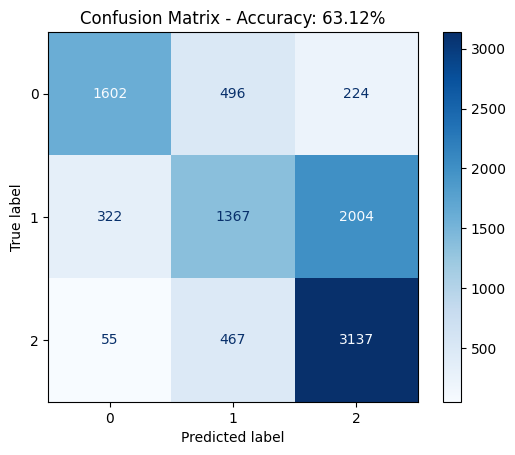

In [ ]:


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
evaluate_model(model, test_loader)

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/model data/potentialmodel.pth')


<ipython-input-19-9fd21f136d81>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/model data/potentialmodel.pth'))


Test Accuracy: 63.12%


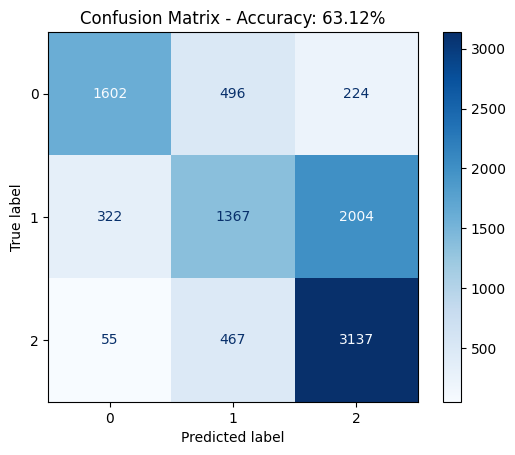

In [ ]:
model = Conv1DQuantumNet().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/model data/potentialmodel.pth'))
model.eval()

evaluate_model(model, test_loader)

In [ ]:
model.train()


Conv1DQuantumNet(
  (conv1): Conv1d(1, 10, kernel_size=(5,), stride=(1,))
  (conv2): Conv1d(10, 20, kernel_size=(5,), stride=(1,))
  (dropout): Dropout(p=0.2, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=99840, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=4, bias=True)
  (q_layer): QuantumLayer(
    (q_layer): <Quantum Torch Layer: func=quantum_circuit>
  )
  (fc3): Linear(in_features=4, out_features=3, bias=True)
)

In [ ]:

train_model(model, train_loader, optimizer, criterion, epochs=2)

Epoch 1/2: 100%|██████████| 1210/1210 [22:46<00:00,  1.13s/it, loss=1.05]


Epoch 1 Loss: 0.7286


Epoch 2/2: 100%|██████████| 1210/1210 [21:46<00:00,  1.08s/it, loss=0.761]

Epoch 2 Loss: 0.7264


Test Accuracy: 63.12%


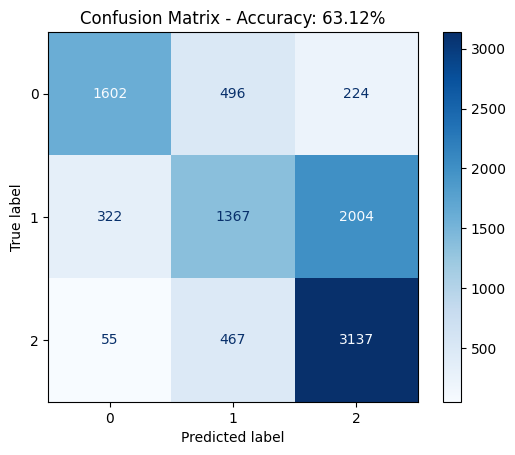

In [ ]:
evaluate_model(model, test_loader)

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/model data/potentialmodelretrained.pth')